Dataset loaded. Shape: (7214, 40)
Columns in the dataset:
['id', 'name', 'first', 'last', 'compas_screening_date', 'gender', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score_risk', 'juv_misd_count', 'juv_other_count', 'priors_count_risk', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'is_violent_recid', 'type_of_assessment', 'decile_score_violence', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count_violence', 'start', 'end', 'event', 'two_year_recid']
Checking for missing values...
id                         0
name                       0
first                      0
last                       0
compas_screening_date      0
gender                     0
dob                        0
age                        0
age_cat                    0
race                 

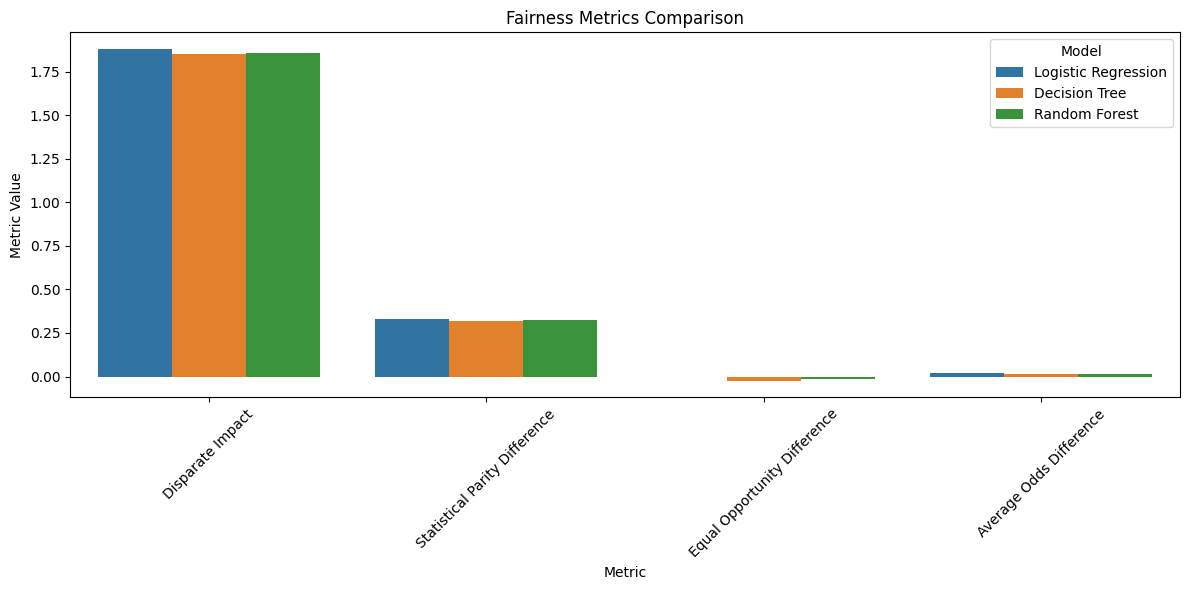

In [11]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For fairness metrics
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the Dataset
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, '..', 'results', 'fair_mask_compa_race.csv')

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print(f"Dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Dataset file '{dataset_path}' not found.")
    sys.exit(1)

# Inspect the columns in the dataset
print("Columns in the dataset:")
print(df.columns.tolist())

# Step 2: Define Label and Protected Attributes
label_column = 'two_year_recid'  # Adjust based on your dataset
protected_attribute = 'race'  # Adjust based on your dataset

# Check if label and protected attribute exist
if label_column not in df.columns:
    raise ValueError(f"Label column '{label_column}' not found in the dataset.")
if protected_attribute not in df.columns:
    raise ValueError(f"Protected attribute '{protected_attribute}' not found in the dataset.")

# Step 3: Handle Missing Values
print("Checking for missing values...")
print(df.isnull().sum())
df = df.dropna()  # Drop rows with missing values
print(f"Dataset after dropping missing values. Shape: {df.shape}")

# Step 4: Data Preparation
# Separate features and labels
X_full = df.drop(columns=[label_column])
y = df[label_column]

# Split into training and test sets
try:
    X_full_train, X_full_test, y_train, y_test = train_test_split(
        X_full, y, test_size=0.2, stratify=y, random_state=42
    )
except ValueError as e:
    print(f"Error during train-test split: {e}")
    sys.exit(1)

# Remove the protected attribute for training
X_train = X_full_train.drop(columns=[protected_attribute])
X_test = X_full_test.drop(columns=[protected_attribute])

# Optionally, reset indices
X_full_test = X_full_test.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_full_train = X_full_train.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 5: Scale Features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the Models
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 7: Evaluate the Models
# Logistic Regression Performance
lr_y_pred = lr_model.predict(X_test_scaled)
lr_y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
print("\nLogistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, lr_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, lr_y_proba))
print("Classification Report:\n", classification_report(y_test, lr_y_pred))

# Decision Tree Performance
dt_y_pred = dt_model.predict(X_test)
dt_y_proba = dt_model.predict_proba(X_test)[:, 1]
print("\nDecision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, dt_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, dt_y_proba))
print("Classification Report:\n", classification_report(y_test, dt_y_pred))

# Random Forest Performance
rf_y_pred = rf_model.predict(X_test)
rf_y_proba = rf_model.predict_proba(X_test)[:, 1]
print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_y_proba))
print("Classification Report:\n", classification_report(y_test, rf_y_pred))

# Step 8: Fairness Metrics Assessment
# Include the protected attribute in the test set
test_df = X_test.copy()
test_df[label_column] = y_test
test_df[protected_attribute] = X_full_test[protected_attribute]

# Create BinaryLabelDataset for test data
dataset_test = BinaryLabelDataset(
    df=test_df,
    label_names=[label_column],
    protected_attribute_names=[protected_attribute]
)

# Function to create predicted datasets
def create_pred_dataset(y_pred, X_test, label_column, protected_attribute):
    df_pred = X_test.copy()
    df_pred[label_column] = y_pred
    df_pred[protected_attribute] = X_full_test[protected_attribute]
    return BinaryLabelDataset(
        df=df_pred,
        label_names=[label_column],
        protected_attribute_names=[protected_attribute]
    )

# Create datasets with predictions
dataset_pred_lr = create_pred_dataset(lr_y_pred, X_test, label_column, protected_attribute)
dataset_pred_dt = create_pred_dataset(dt_y_pred, X_test, label_column, protected_attribute)
dataset_pred_rf = create_pred_dataset(rf_y_pred, X_test, label_column, protected_attribute)

# Define unprivileged and privileged groups
unprivileged_groups = [{protected_attribute: 0}]
privileged_groups = [{protected_attribute: 1}]

# Function to compute fairness metrics
def compute_fairness_metrics(dataset_true, dataset_pred):
    metric = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    metrics = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Equal Opportunity Difference': metric.equal_opportunity_difference(),
        'Average Odds Difference': metric.average_odds_difference()
    }
    return metrics

# Compute fairness metrics
metrics_lr = compute_fairness_metrics(dataset_test, dataset_pred_lr)
metrics_dt = compute_fairness_metrics(dataset_test, dataset_pred_dt)
metrics_rf = compute_fairness_metrics(dataset_test, dataset_pred_rf)

# Print fairness metrics
print("\nFairness Metrics for Logistic Regression:")
for k, v in metrics_lr.items():
    print(f"{k}: {v:.4f}")

print("\nFairness Metrics for Decision Tree:")
for k, v in metrics_dt.items():
    print(f"{k}: {v:.4f}")

print("\nFairness Metrics for Random Forest:")
for k, v in metrics_rf.items():
    print(f"{k}: {v:.4f}")

# Step 9: Visualize Fairness Metrics (Optional)
metrics_df = pd.DataFrame({
    'Metric': ['Disparate Impact', 'Statistical Parity Difference', 'Equal Opportunity Difference', 'Average Odds Difference'],
    'Logistic Regression': list(metrics_lr.values()),
    'Decision Tree': list(metrics_dt.values()),
    'Random Forest': list(metrics_rf.values())
})

metrics_df_melted = metrics_df.melt(id_vars='Metric', var_name='Model', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_df_melted)
plt.title('Fairness Metrics Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [3]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For fairness metrics
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/envs/aif360_env/lib/python3.9/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/envs/aif360_env/lib/python3.9/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_

In [4]:
# Step 2: Load the Dataset
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, '..', 'results', 'fair_mask_compa_race.csv')

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print(f"Dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Dataset file '{dataset_path}' not found.")
    sys.exit(1)

# Inspect the columns in the dataset
print("Columns in the dataset:")
print(df.columns.tolist())


Dataset loaded. Shape: (7214, 40)
Columns in the dataset:
['id', 'name', 'first', 'last', 'compas_screening_date', 'gender', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score_risk', 'juv_misd_count', 'juv_other_count', 'priors_count_risk', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'is_violent_recid', 'type_of_assessment', 'decile_score_violence', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count_violence', 'start', 'end', 'event', 'two_year_recid']


In [5]:
# Step 3: Define Label and Protected Attributes
label_column = 'two_year_recid'  # Adjust based on your dataset
protected_attribute = 'race'  # Adjust based on your dataset

# Check if label and protected attribute exist
if label_column not in df.columns:
    raise ValueError(f"Label column '{label_column}' not found in the dataset.")
if protected_attribute not in df.columns:
    raise ValueError(f"Protected attribute '{protected_attribute}' not found in the dataset.")


In [6]:
# Step 4: Handle Missing Values
print("Checking for missing values...")
print(df.isnull().sum())
df = df.dropna()  # Drop rows with missing values
print(f"Dataset after dropping missing values. Shape: {df.shape}")


Checking for missing values...
id                         0
name                       0
first                      0
last                       0
compas_screening_date      0
gender                     0
dob                        0
age                        0
age_cat                    0
race                       0
juv_fel_count              0
decile_score_risk          0
juv_misd_count             0
juv_other_count            0
priors_count_risk          0
days_b_screening_arrest    0
c_jail_in                  0
c_jail_out                 0
c_case_number              0
c_offense_date             0
c_days_from_compas         0
c_charge_degree            0
c_charge_desc              0
is_recid                   0
is_violent_recid           0
type_of_assessment         0
decile_score_violence      0
score_text                 0
screening_date             0
v_type_of_assessment       0
v_decile_score             0
v_score_text               0
v_screening_date           0
in_custody  

In [7]:
# Step 5: Data Preparation
# Separate features and labels
X_full = df.drop(columns=[label_column])
y = df[label_column]

# Split into training and test sets
X_full_train, X_full_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

# Remove the protected attribute for training
X_train = X_full_train.drop(columns=[protected_attribute])
X_test = X_full_test.drop(columns=[protected_attribute])


In [8]:
# Step 6: Scale Features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [10]:
# Logistic Regression Performance
lr_y_pred = lr_model.predict(X_test_scaled)
lr_y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
print("\nLogistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, lr_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, lr_y_proba))
print("Classification Report:\n", classification_report(y_test, lr_y_pred))

# Decision Tree Performance
dt_y_pred = dt_model.predict(X_test)
dt_y_proba = dt_model.predict_proba(X_test)[:, 1]
print("\nDecision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, dt_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, dt_y_proba))
print("Classification Report:\n", classification_report(y_test, dt_y_pred))

# Random Forest Performance
rf_y_pred = rf_model.predict(X_test)
rf_y_proba = rf_model.predict_proba(X_test)[:, 1]
print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_y_proba))
print("Classification Report:\n", classification_report(y_test, rf_y_pred))



Logistic Regression Performance:
Accuracy: 0.9930699930699931
ROC AUC Score: 0.9998976484202347
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       926
         1.0       0.98      1.00      0.99       517

    accuracy                           0.99      1443
   macro avg       0.99      0.99      0.99      1443
weighted avg       0.99      0.99      0.99      1443


Decision Tree Performance:
Accuracy: 0.9833679833679834
ROC AUC Score: 0.9819151024977963
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       926
         1.0       0.98      0.98      0.98       517

    accuracy                           0.98      1443
   macro avg       0.98      0.98      0.98      1443
weighted avg       0.98      0.98      0.98      1443


Random Forest Performance:
Accuracy: 0.9902979902979903
ROC AUC Score: 0.9995979045080648
Classification Repo

In [11]:
# Include the protected attribute in the test set
test_df = X_test.copy()
test_df[label_column] = y_test
test_df[protected_attribute] = X_full_test[protected_attribute]

# Create BinaryLabelDataset for test data
dataset_test = BinaryLabelDataset(
    df=test_df,
    label_names=[label_column],
    protected_attribute_names=[protected_attribute]
)

# Function to create predicted datasets
def create_pred_dataset(y_pred, X_test, label_column, protected_attribute):
    df_pred = X_test.copy()
    df_pred[label_column] = y_pred
    df_pred[protected_attribute] = X_full_test[protected_attribute]
    return BinaryLabelDataset(
        df=df_pred,
        label_names=[label_column],
        protected_attribute_names=[protected_attribute]
    )

# Create datasets with predictions
dataset_pred_lr = create_pred_dataset(lr_y_pred, X_test, label_column, protected_attribute)
dataset_pred_dt = create_pred_dataset(dt_y_pred, X_test, label_column, protected_attribute)
dataset_pred_rf = create_pred_dataset(rf_y_pred, X_test, label_column, protected_attribute)


In [17]:
def calculate_wc_spd(df, label_column, protected_attributes):
    """
    Weighted Conditional Statistical Parity Difference (WC-SPD).
    """
    group_stats = []
    total_instances = len(df)
    
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        favorable_prob = subset[label_column].mean()
        weight = len(subset) / total_instances
        group_stats.append((favorable_prob, weight))
    
    # Compute WC-SPD
    wc_spd = sum(weight * prob for prob, weight in group_stats)
    return wc_spd

def calculate_wc_aod(df, label_column, protected_attributes, y_pred_col):
    """
    Weighted Conditional Average Odds Difference (WC-AOD).
    Handles cases where there are no positive or negative labels in a group.
    """
    group_stats = []
    total_instances = len(df)
    
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        # Safeguard for groups with no positive or negative labels
        if sum(subset[label_column] == 1) == 0 or sum(subset[label_column] == 0) == 0:
            continue  # Skip groups with no positive or negative samples
        
        tpr = sum((subset[label_column] == 1) & (subset[y_pred_col] == 1)) / sum(subset[label_column] == 1)
        fpr = sum((subset[label_column] == 0) & (subset[y_pred_col] == 1)) / sum(subset[label_column] == 0)
        weight = len(subset) / total_instances
        group_stats.append((tpr, fpr, weight))
    
    # Compute WC-AOD
    wc_aod = sum(weight * (tpr - fpr) for tpr, fpr, weight in group_stats) if group_stats else 0
    return wc_aod

def calculate_ac_spd(df, label_column, protected_attributes):
    """
    Average Conditional Statistical Parity Difference (AC-SPD).
    """
    group_stats = []
    for combination in df.groupby(protected_attributes):
        _, subset = combination
        favorable_prob = subset[label_column].mean()
        group_stats.append(favorable_prob)
    
    # Compute AC-SPD as the average difference between groups
    spd_values = [abs(prob1 - prob2) for i, prob1 in enumerate(group_stats) 
                  for j, prob2 in enumerate(group_stats) if i < j]
    ac_spd = sum(spd_values) / len(spd_values) if spd_values else 0
    return ac_spd


In [18]:
# Logistic Regression Predictions
test_df_lr = test_df.copy()
test_df_lr['y_pred'] = lr_y_pred

# Decision Tree Predictions
test_df_dt = test_df.copy()
test_df_dt['y_pred'] = dt_y_pred

# Random Forest Predictions
test_df_rf = test_df.copy()
test_df_rf['y_pred'] = rf_y_pred


In [19]:
# Compute Intersectional Fairness Metrics for Logistic Regression
wc_spd_lr = calculate_wc_spd(test_df_lr, label_column, [protected_attribute])
wc_aod_lr = calculate_wc_aod(test_df_lr, label_column, [protected_attribute], 'y_pred')
ac_spd_lr = calculate_ac_spd(test_df_lr, label_column, [protected_attribute])

print("\nLogistic Regression Intersectional Fairness Metrics:")
print(f"WC-SPD: {wc_spd_lr:.4f}")
print(f"WC-AOD: {wc_aod_lr:.4f}")
print(f"AC-SPD: {ac_spd_lr:.4f}")



Logistic Regression Intersectional Fairness Metrics:
WC-SPD: 0.3583
WC-AOD: 0.4969
AC-SPD: 0.3065


In [20]:
# Compute Intersectional Fairness Metrics for Decision Tree
wc_spd_dt = calculate_wc_spd(test_df_dt, label_column, [protected_attribute])
wc_aod_dt = calculate_wc_aod(test_df_dt, label_column, [protected_attribute], 'y_pred')
ac_spd_dt = calculate_ac_spd(test_df_dt, label_column, [protected_attribute])

print("\nDecision Tree Intersectional Fairness Metrics:")
print(f"WC-SPD: {wc_spd_dt:.4f}")
print(f"WC-AOD: {wc_aod_dt:.4f}")
print(f"AC-SPD: {ac_spd_dt:.4f}")



Decision Tree Intersectional Fairness Metrics:
WC-SPD: 0.3583
WC-AOD: 0.4792
AC-SPD: 0.3065


In [21]:
# Compute Intersectional Fairness Metrics for Random Forest
wc_spd_rf = calculate_wc_spd(test_df_rf, label_column, [protected_attribute])
wc_aod_rf = calculate_wc_aod(test_df_rf, label_column, [protected_attribute], 'y_pred')
ac_spd_rf = calculate_ac_spd(test_df_rf, label_column, [protected_attribute])

print("\nRandom Forest Intersectional Fairness Metrics:")
print(f"WC-SPD: {wc_spd_rf:.4f}")
print(f"WC-AOD: {wc_aod_rf:.4f}")
print(f"AC-SPD: {ac_spd_rf:.4f}")



Random Forest Intersectional Fairness Metrics:
WC-SPD: 0.3583
WC-AOD: 0.4942
AC-SPD: 0.3065


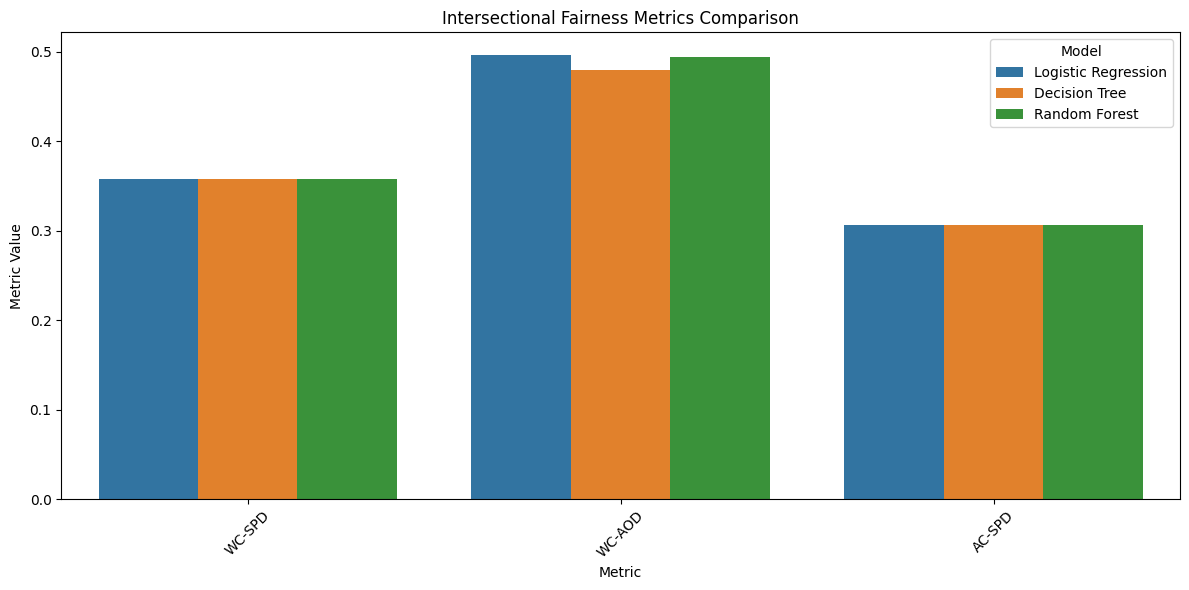

In [22]:
# Combine Metrics for All Models
metrics_df_intersectional = pd.DataFrame({
    'Metric': ['WC-SPD', 'WC-AOD', 'AC-SPD'],
    'Logistic Regression': [wc_spd_lr, wc_aod_lr, ac_spd_lr],
    'Decision Tree': [wc_spd_dt, wc_aod_dt, ac_spd_dt],
    'Random Forest': [wc_spd_rf, wc_aod_rf, ac_spd_rf]
})

# Reshape DataFrame for Plotting
metrics_df_intersectional_melted = metrics_df_intersectional.melt(
    id_vars='Metric', var_name='Model', value_name='Value'
)

# Plot Metrics Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_df_intersectional_melted)
plt.title('Intersectional Fairness Metrics Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
